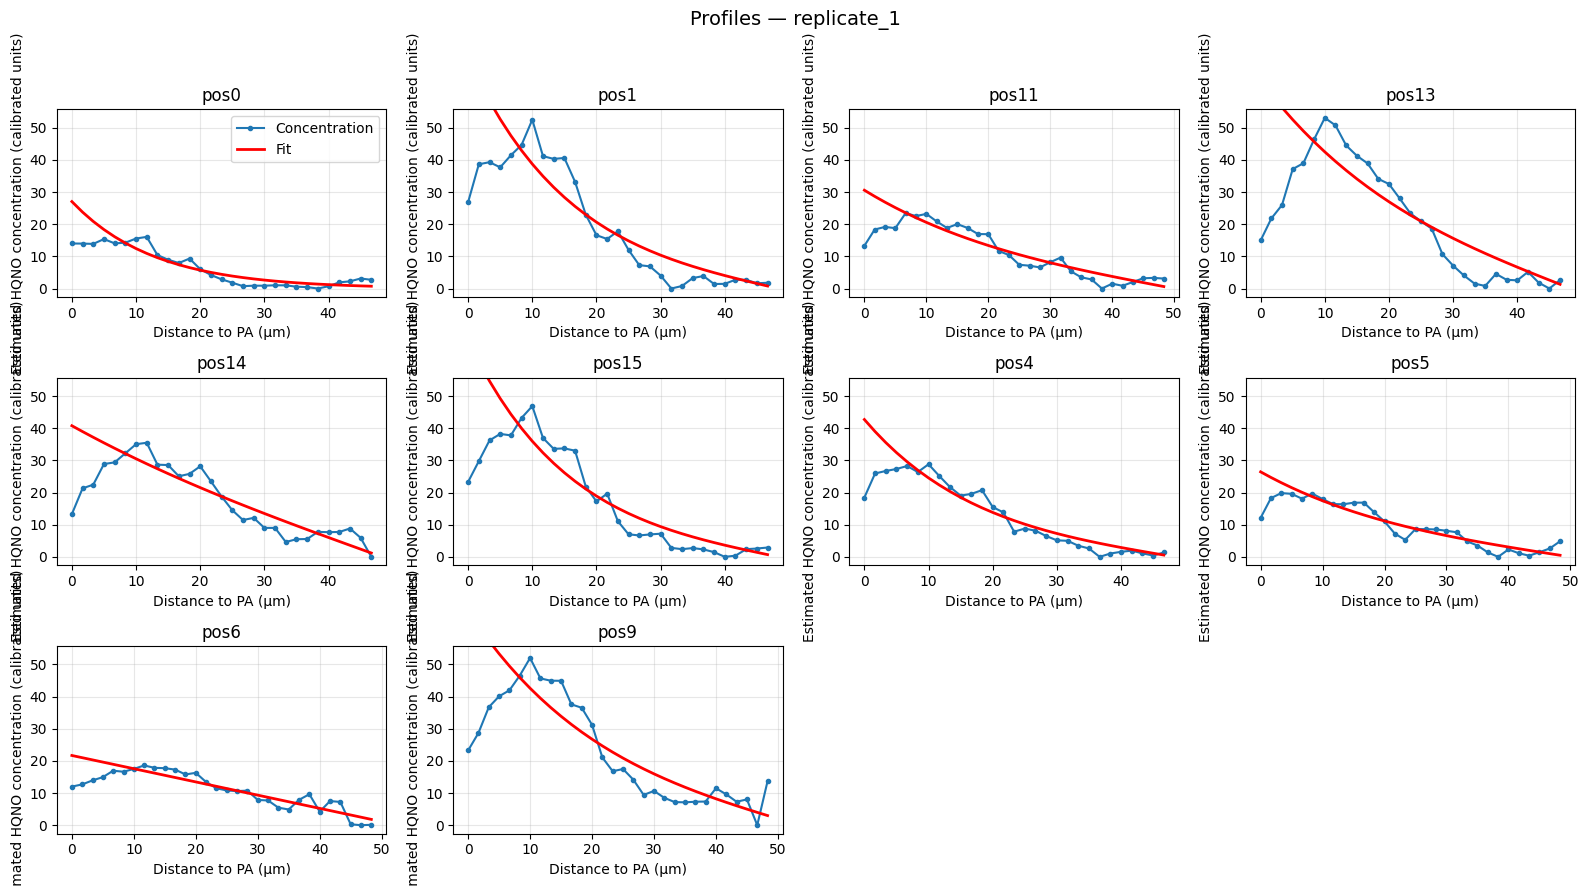

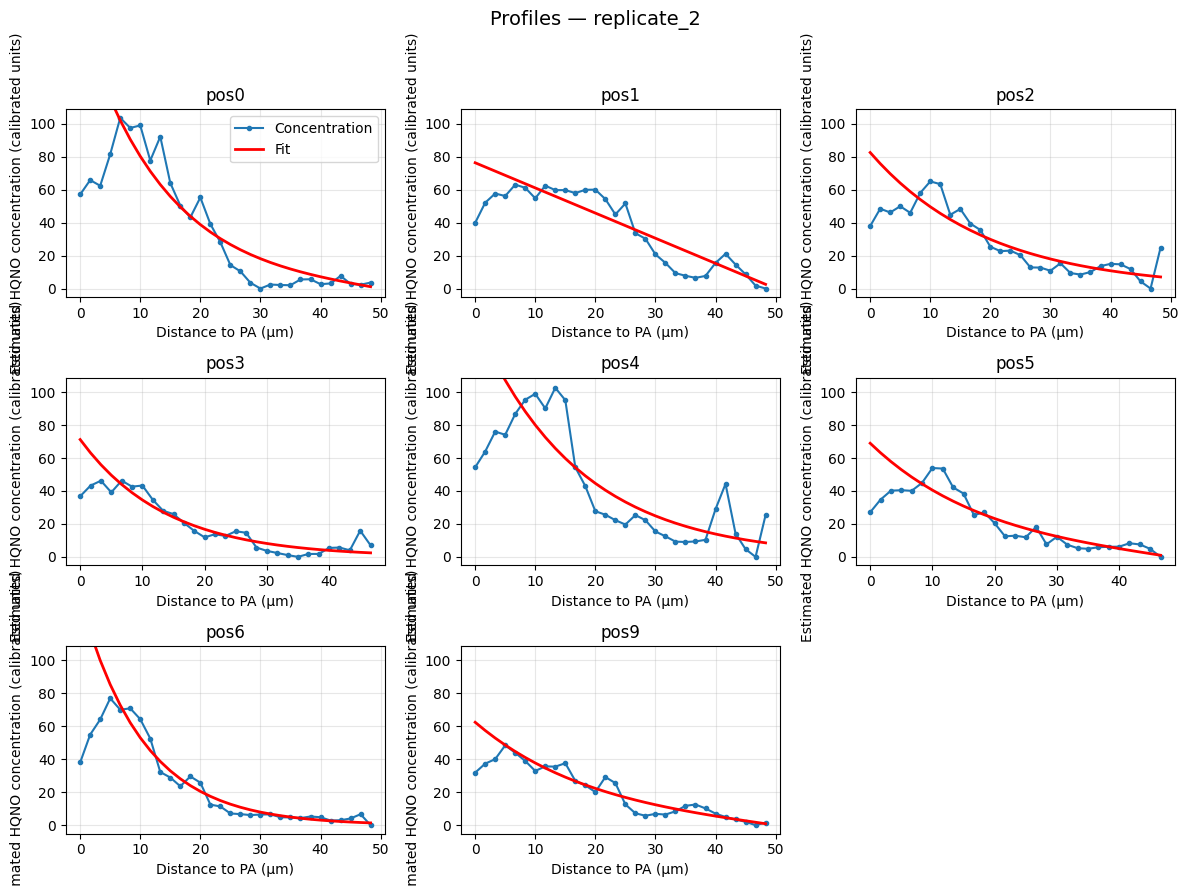

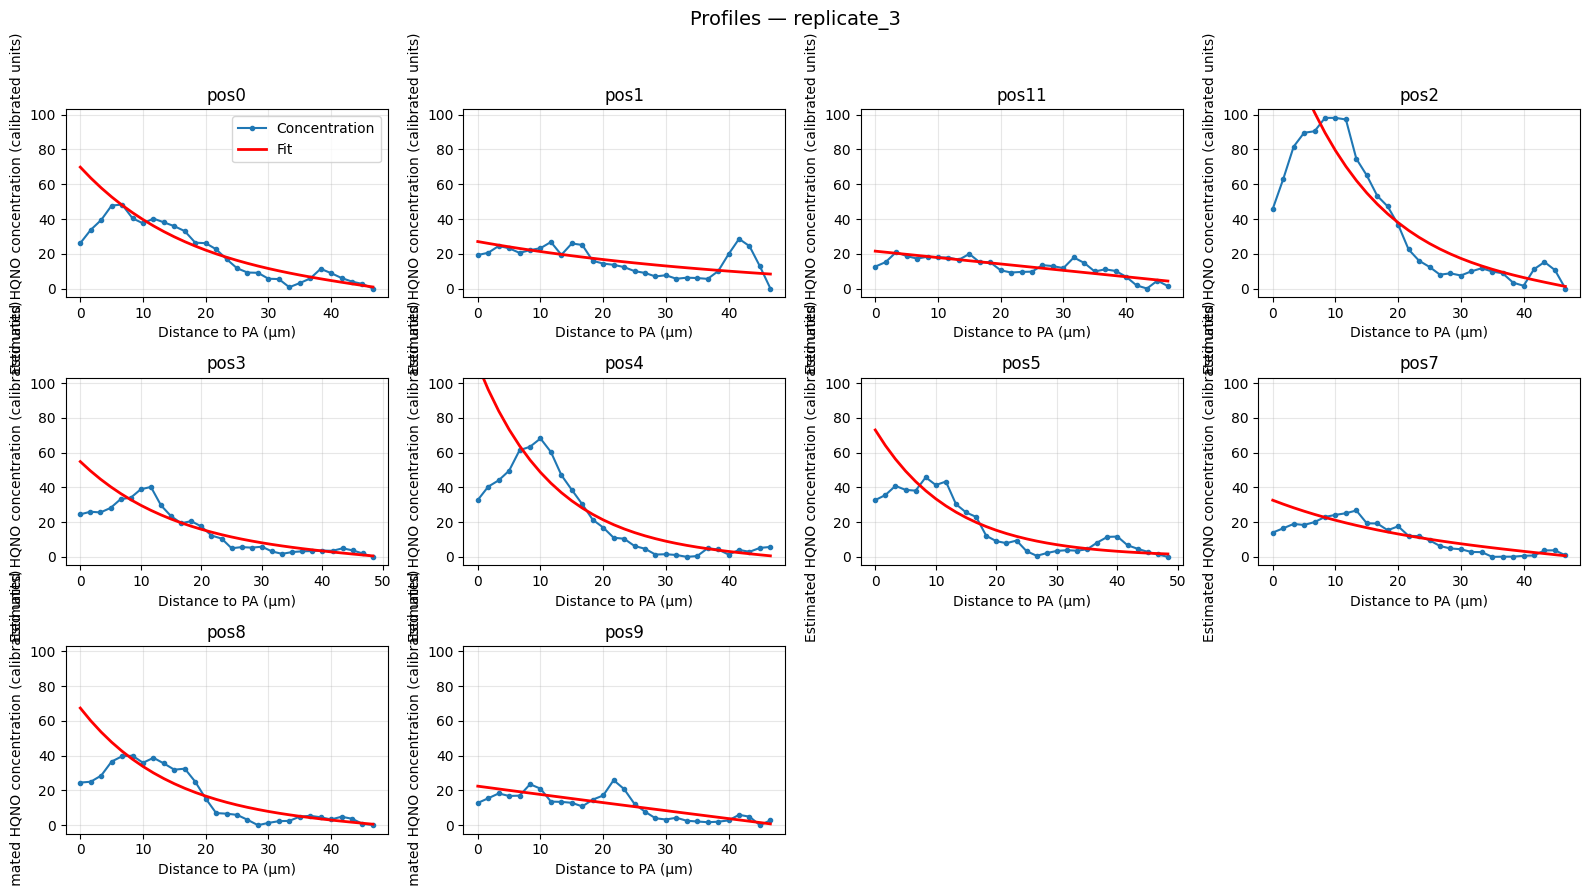

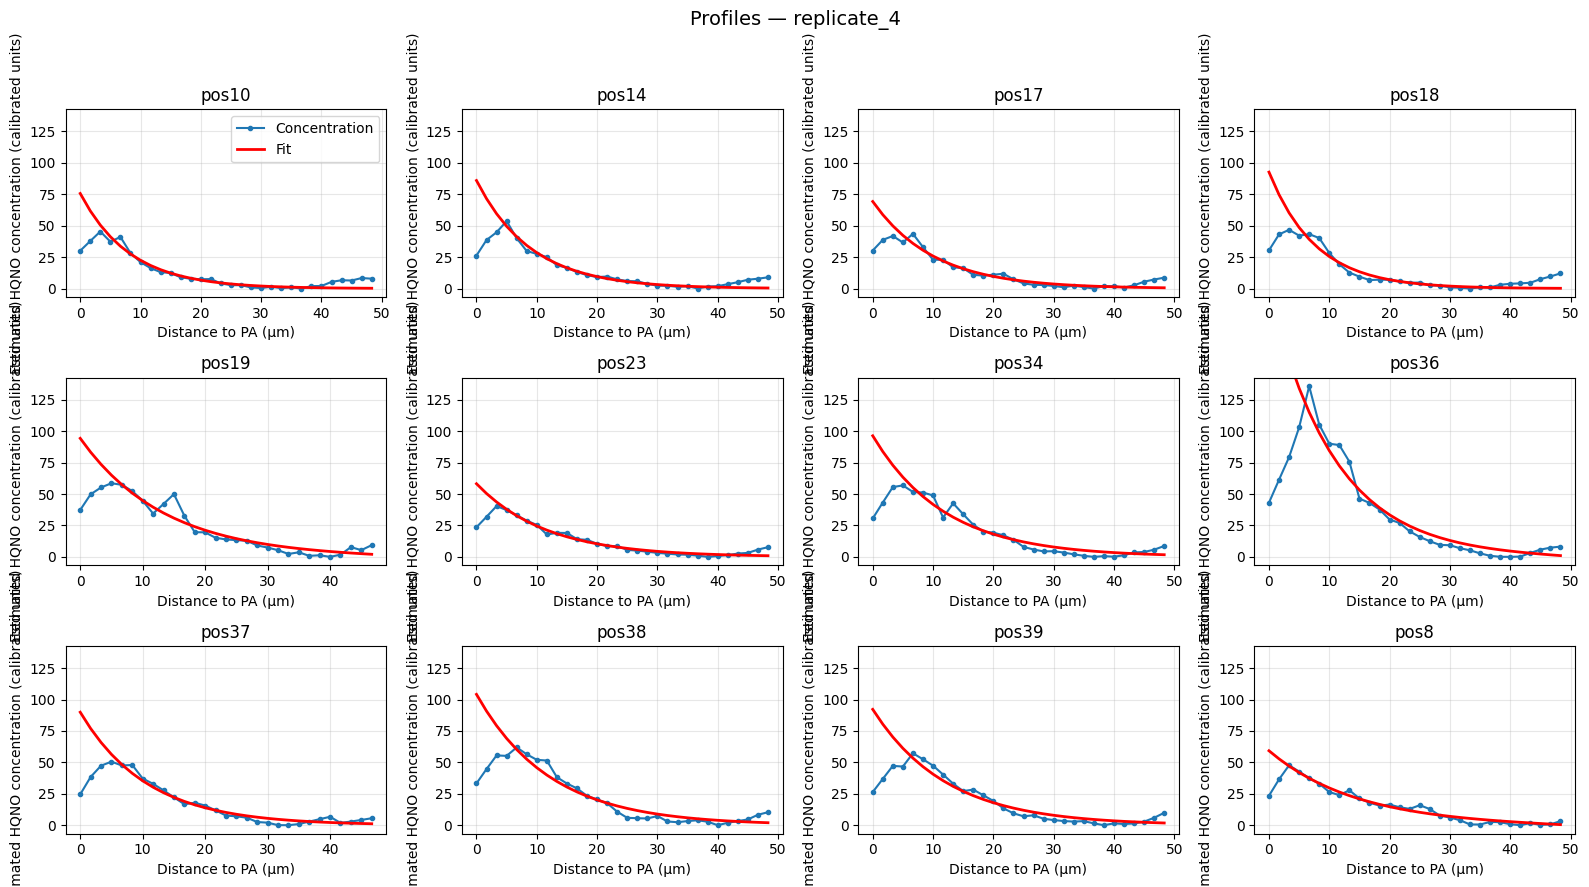

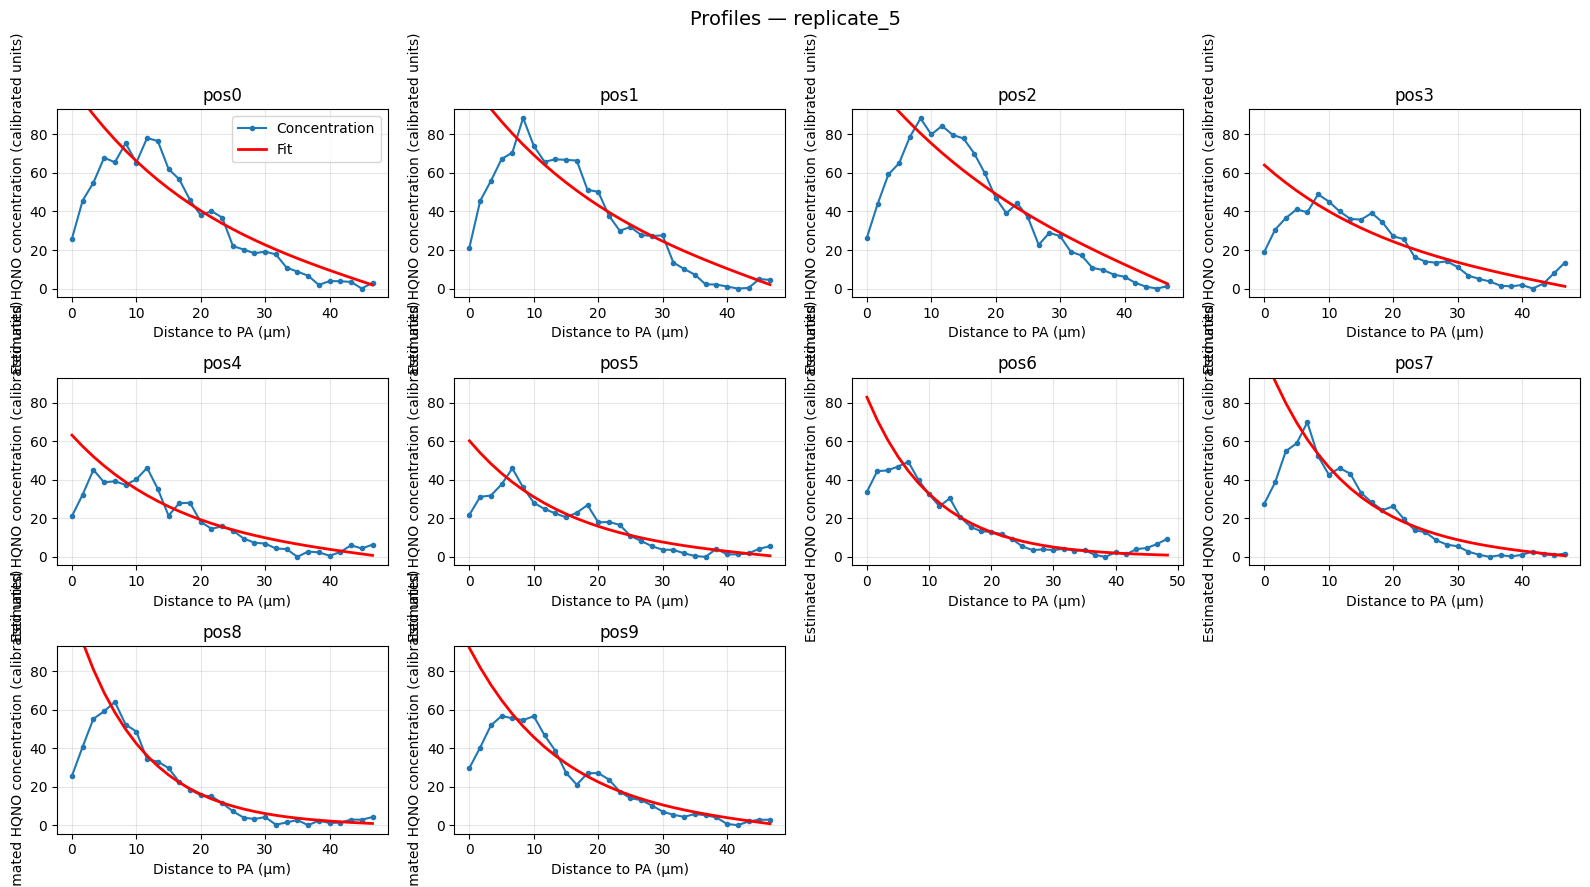

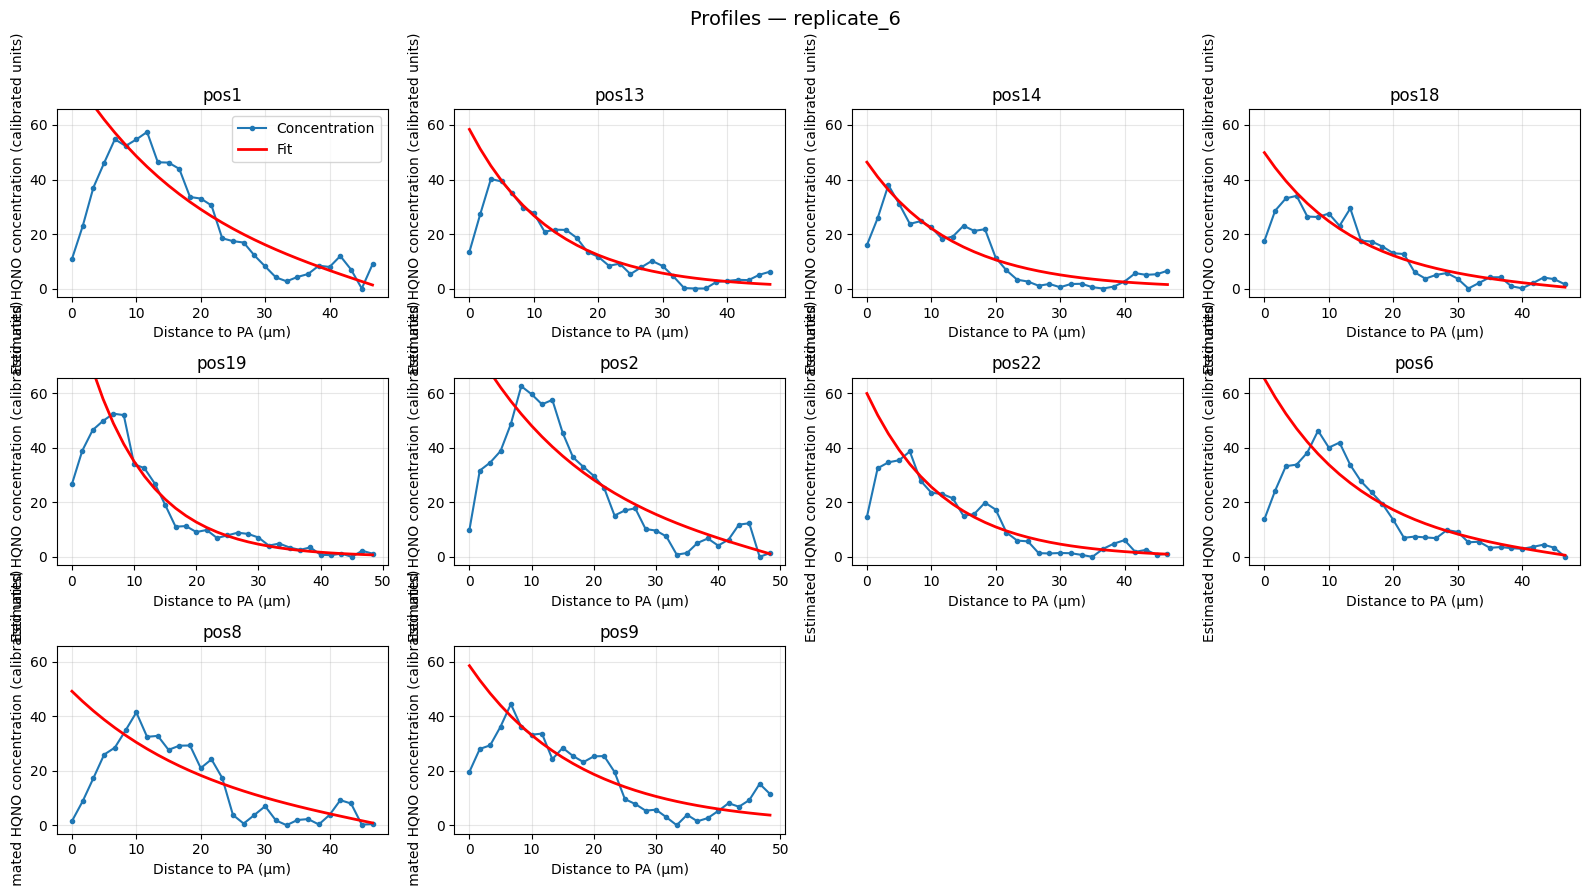

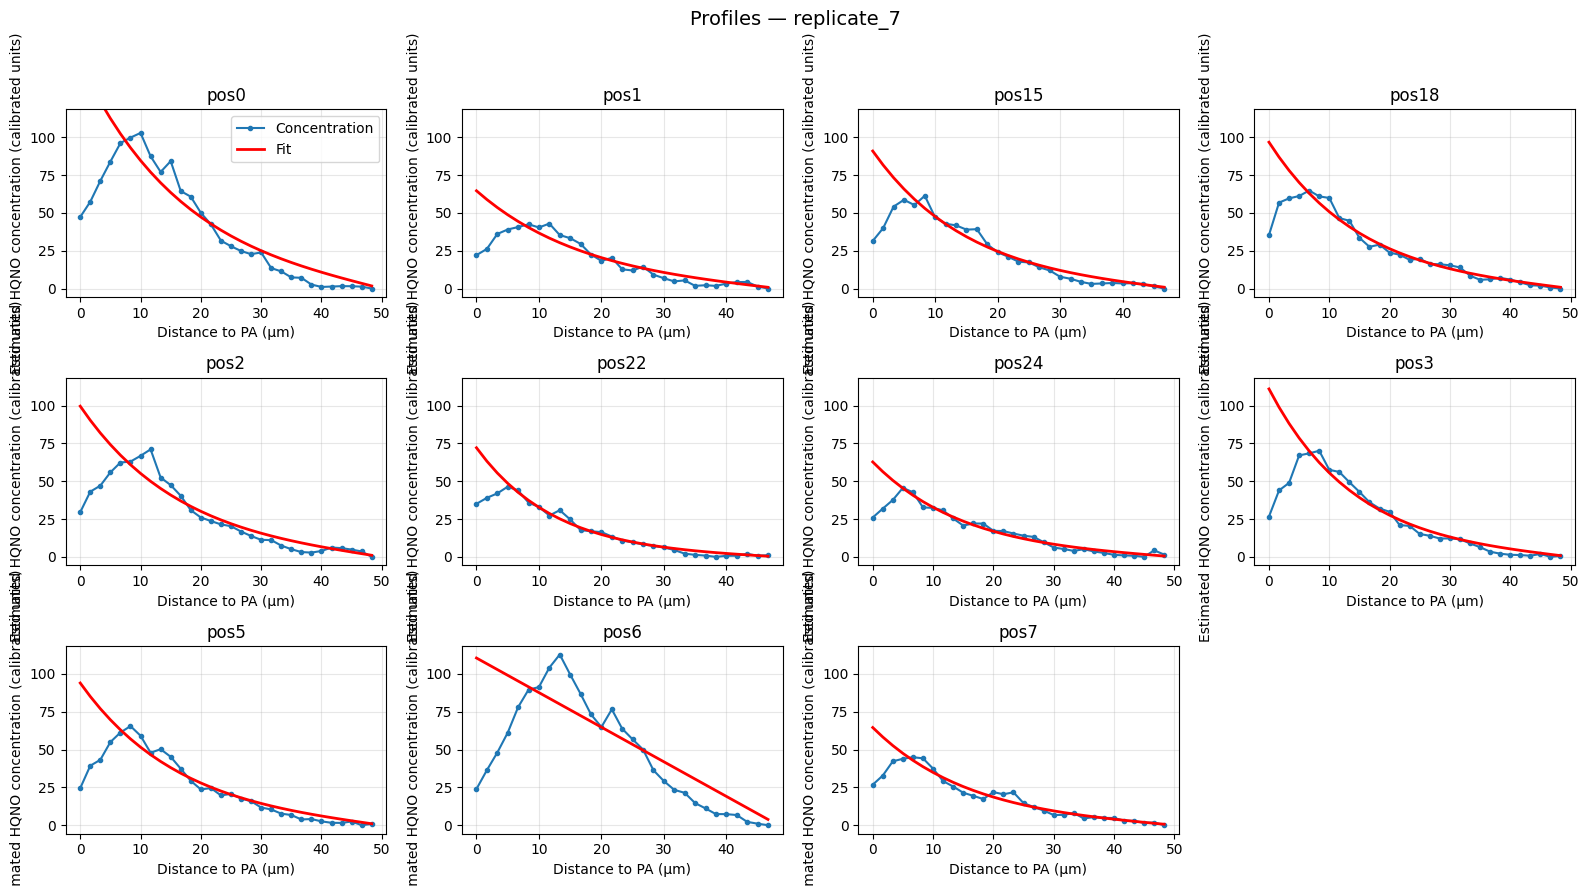

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---- Config ----
PROFILES_CSV        = r'3C_HQNO_concentration_profiles.csv'  # per-bin profiles you saved
PREFERRED_VALUE_COL = 'estimated_hqno_concentration'         # calibrated concentration (preferred)
ALT_INTENSITY_COL   = 'intensity_bg_corrected'               # already bg-corrected intensity (clipped ≥0)
FIT_COL             = 'fit_y'                                

REPLICATE_COL = 'replicate'
CHAMBER_COL   = 'pos'
X_BIN_COL     = 'y_bin'
X_PHYS_COL    = 'x_physical'  # if present and not all NaN, x-axis will use this in physical units

# ---- Load ----
df = pd.read_csv(PROFILES_CSV)

# Decide what to plot (no bg calculation here)
if PREFERRED_VALUE_COL in df.columns:
    VALUE_COL = PREFERRED_VALUE_COL
    y_label = 'Estimated HQNO concentration (calibrated units)'
elif ALT_INTENSITY_COL in df.columns:
    VALUE_COL = ALT_INTENSITY_COL
    y_label = 'Background-corrected intensity (a.u.)'
else:
    raise ValueError(
        f"Expected '{PREFERRED_VALUE_COL}' or '{ALT_INTENSITY_COL}' in {PROFILES_CSV}."
    )

# Choose x-axis (physical if available, otherwise y_bin)
use_physical = (X_PHYS_COL in df.columns) and df[X_PHYS_COL].notna().any()
x_col = X_PHYS_COL if use_physical else X_BIN_COL
x_label = "Distance to PA (µm)" if use_physical else "Distance to PA (bins)"

# ---- Plot per replicate: a panel of subplots (one per chamber) ----
for rep in sorted(df[REPLICATE_COL].dropna().unique()):
    df_rep = df[df[REPLICATE_COL] == rep].copy()
    chambers = sorted(df_rep[CHAMBER_COL].dropna().unique())
    if not chambers:
        continue

    n = len(chambers)
    ncols = int(np.ceil(np.sqrt(n)))
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                             figsize=(4*ncols, 3*nrows), squeeze=False)
    fig.suptitle(f'Profiles — {rep}', fontsize=14)
    axes = axes.ravel()

    has_fit = FIT_COL in df_rep.columns

    # Consistent y-limits across subplots for the chosen value column
    y_min = pd.to_numeric(df_rep[VALUE_COL], errors='coerce').min(skipna=True)
    y_max = pd.to_numeric(df_rep[VALUE_COL], errors='coerce').max(skipna=True)
    span = (y_max - y_min) if (np.isfinite(y_min) and np.isfinite(y_max)) else np.nan
    y_pad = 0.05 * (span if np.isfinite(span) else 1.0)

    for i, pos in enumerate(chambers):
        ax = axes[i]
        d = df_rep[df_rep[CHAMBER_COL] == pos].copy().sort_values(x_col)

        # plot the selected profile as a line with markers
        label_main = 'Concentration' if VALUE_COL == PREFERRED_VALUE_COL else 'BG-corrected intensity'
        ax.plot(d[x_col], d[VALUE_COL], '-o', ms=3, lw=1.5, label=label_main)

        # overlay fit if available (same units as VALUE_COL when VALUE_COL is concentration)
        if has_fit and d[FIT_COL].notna().any():
            d_fit = d[[x_col, FIT_COL]].dropna().sort_values(x_col)
            if len(d_fit) > 1:
                ax.plot(d_fit[x_col], d_fit[FIT_COL], 'r-', lw=2, label='Fit')

        ax.set_title(str(pos))
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.grid(True, alpha=0.3)
        if np.isfinite(y_min) and np.isfinite(y_max):
            ax.set_ylim(y_min - y_pad, y_max + y_pad)

        if i == 0 and has_fit:
            ax.legend()

    # turn off any unused axes
    for j in range(n, len(axes)):
        axes[j].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

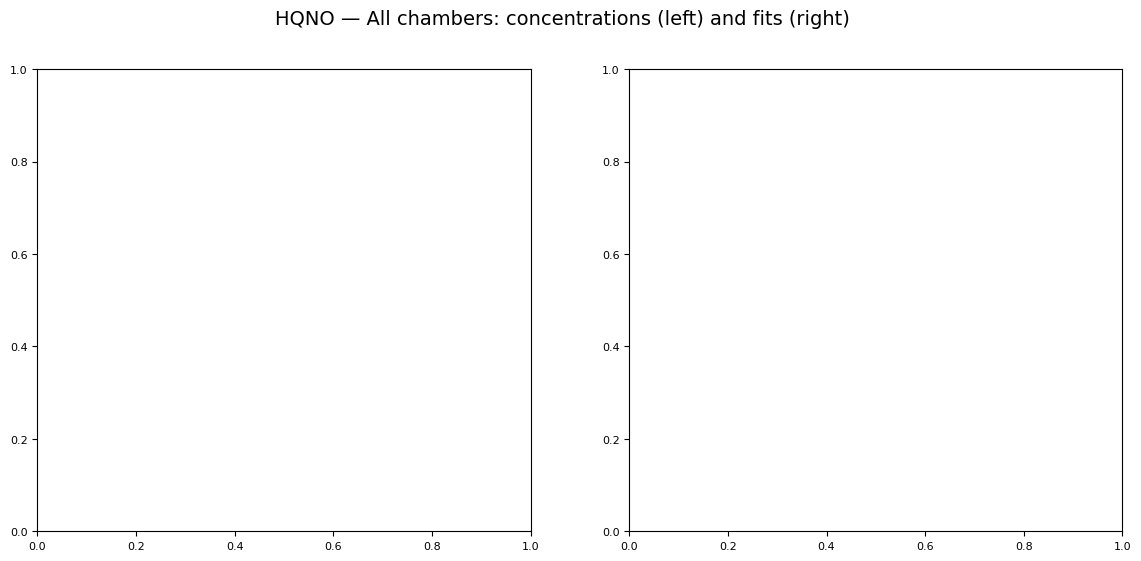

In [2]:
# === Plot all chambers: data (left) and fits (right) — HQNO ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load profiles (use existing OUTPUT_PROFILE_CSV from previous cell if available)
try:
    PROFILES_CSV = OUTPUT_PROFILE_CSV
except NameError:
    PROFILES_CSV = r'3C_HQNO_concentration_profiles.csv'  # HQNO fallback path

df = pd.read_csv(PROFILES_CSV)

# Choose x-axis (physical if available, otherwise y_bin)
x_col = 'x_physical' if ('x_physical' in df.columns and df['x_physical'].notna().any()) else 'y_bin'
x_label = "Distance to PA (µm)" if x_col == 'x_physical' else "Distance to PA (bins)"

# Choose the concentration column (prefer HQNO naming, fallback to RHL if needed)
if 'estimated_hqno_concentration' in df.columns:
    conc_col = 'estimated_hqno_concentration'
elif 'estimated_rhl_concentration' in df.columns:
    conc_col = 'estimated_rhl_concentration'
else:
    raise ValueError("No concentration column found. Expected 'estimated_hqno_concentration' or 'estimated_rhl_concentration'.")

fit_col = 'fit_y' if 'fit_y' in df.columns else None

# Colors by replicate (repeat if more than colormap size)
reps = sorted(df['replicate'].dropna().unique())
cmap = plt.get_cmap('tab20')
rep_color = {rep: cmap(i % cmap.N) for i, rep in enumerate(reps)}

# Create figure with two axes
fig, (ax_data, ax_fit) = plt.subplots(1, 2, figsize=(14, 6), sharex=True)
fig.suptitle('HQNO — All chambers: concentrations (left) and fits (right)', fontsize=14)

# Plot all chamber concentrations on the left axis
lines_plotted_data = 0
for rep in reps:
    drep = df[df['replicate'] == rep]
    for pos, dpos in drep.groupby('pos'):
        dpos = dpos.sort_values(x_col)
        y = pd.to_numeric(dpos[conc_col], errors='coerce')
        if y.notna().any():
            ax_data.plot(dpos[x_col], y, '-', lw=1.2, alpha=0.7, color=rep_color[rep])
            lines_plotted_data += 1

# Plot all chamber fits on the right axis (if available)
lines_plotted_fit = 0
if fit_col is not None:
    for rep in reps:
        drep = df[df['replicate'] == rep]
        for pos, dpos in drep.groupby('pos'):
            dpos = dpos[[x_col, fit_col]].dropna().sort_values(x_col)
            if len(dpos) > 1:
                ax_fit.plot(dpos[x_col], dpos[fit_col], '-', lw=1.6, alpha=0.9, color=rep_color[rep])
                lines_plotted_fit += 1
else:
    ax_fit.text(0.5, 0.5, "No 'fit_y' column found", ha='center', va='center', transform=ax_fit.transAxes)

# Labels, grids, and tidy layout
ax_data.set_xlabel(x_label); ax_data.set_ylabel('HQNO concentration (calibrated units)')
ax_fit.set_xlabel(x_label);  ax_fit.set_ylabel('HQNO concentration (calibrated units)')

ax_data.grid(True, alpha=0.3); ax_fit.grid(True, alpha=0.3)

# Optional: make y-limits consistent across both axes
y_all = pd.to_numeric(df[conc_col], errors='coerce')
if y_all.notna().any():
    ymin, ymax = float(np.nanmin(y_all)), float(np.nanmax(y_all))
    pad = 0.05 * (ymax - ymin if np.isfinite(ymax - ymin) else 1.0)
    if np.isfinite(ymin) and np.isfinite(ymax):
        ax_data.set_ylim(ymin - pad, ymax + pad)
        ax_fit.set_ylim(ymin - pad, ymax + pad)

ax_data.set_ylim(bottom=0, top=150)
ax_fit.set_ylim(bottom=0, top=150)
# Minimal legend (replicate swatches) — comment out if you don't want it
from matplotlib.lines import Line2D
handles = [Line2D([0], [0], color=rep_color[r], lw=2) for r in reps]
ax_data.legend(handles, reps, title='Replicate', loc='upper right', fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.95])
print(f"[info] Plotted {lines_plotted_data} chamber data series and {lines_plotted_fit} fit series.")
plt.show()


[info] Plotted 0 fit series from replicates [].


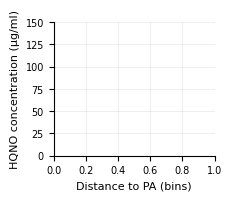

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ——— PNAS figure style ———
final_width_cm = 6    # width in cm
final_height_cm = 5   # height in cm
final_width_in = final_width_cm / 2.54
final_height_in = final_height_cm / 2.54
pnas_fontsize = 8  # points
plt.rcParams.update({
    'font.size': pnas_fontsize,
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

# Load profiles
PROFILES_CSV = '/Volumes/ScientificData/Users/Giulia(botgiu00)/Papers/bottacin2025/Analysis/Figures/Figures3/3C_hqno_concentration/3C_HQNO_concentration_profiles.csv'

df = pd.read_csv(PROFILES_CSV)

# Filter for replicates 4, 5, 7 only
df = df[df['replicate'].isin([4, 5, 7])].copy()

# Choose x-axis (physical if available, otherwise y_bin)
x_col = 'x_physical' if ('x_physical' in df.columns and df['x_physical'].notna().any()) else 'y_bin'
x_label = "Distance to PA (µm)" if x_col == 'x_physical' else "Distance to PA (bins)"

# Choose the concentration column (prefer HQNO naming, fallback to RHL if needed)
if 'estimated_hqno_concentration' in df.columns:
    conc_col = 'estimated_hqno_concentration'
elif 'estimated_rhl_concentration' in df.columns:
    conc_col = 'estimated_rhl_concentration'
else:
    raise ValueError("No concentration column found. Expected 'estimated_hqno_concentration' or 'estimated_rhl_concentration'.")

fit_col = 'fit_y' if 'fit_y' in df.columns else None

# Colors by replicate - use distinct colors for clarity
reps = sorted(df['replicate'].dropna().unique())
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
rep_color = {rep: color_palette[i] for i, rep in enumerate(reps)}

# Create figure with single axis for fits only
fig, ax = plt.subplots(figsize=(final_width_in, final_height_in))

# Plot all chamber fits (if available)
lines_plotted_fit = 0
if fit_col is not None:
    for rep in reps:
        drep = df[df['replicate'] == rep]
        for pos, dpos in drep.groupby('pos'):
            dpos = dpos[[x_col, fit_col]].dropna().sort_values(x_col)
            if len(dpos) > 1:
                ax.plot(dpos[x_col], dpos[fit_col], '-', lw=1.5, alpha=0.8, color=rep_color[rep])
                lines_plotted_fit += 1
else:
    ax.text(0.5, 0.5, "No 'fit_y' column found", ha='center', va='center', transform=ax.transAxes)

# Labels and styling
ax.set_xlabel(x_label, fontsize=pnas_fontsize)
ax.set_ylabel('HQNO concentration (µg/ml)', fontsize=pnas_fontsize)
ax.tick_params(labelsize=pnas_fontsize-1)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Grid
ax.grid(True, alpha=0.3, linewidth=0.5)

# Set y-limits
ax.set_ylim(bottom=0, top=150)

# Legend with replicate labels
from matplotlib.lines import Line2D
handles = [Line2D([0], [0], color=rep_color[r], lw=1.5) for r in reps]
labels = [f'Rep {r}' for r in reps]
ax.legend(handles, labels, fontsize=pnas_fontsize-1, frameon=False, loc='upper right')

plt.tight_layout()
print(f"[info] Plotted {lines_plotted_fit} fit series from replicates {reps}.")

# Save outputs
#plt.savefig('3C_HQNO_fits_PNAS.pdf', dpi=300, transparent=True)
#plt.savefig('3C_HQNO_fits_PNAS.png', dpi=300, transparent=True)
plt.show()


[info] Plotted 33 fit series from replicates [4, 5, 7].


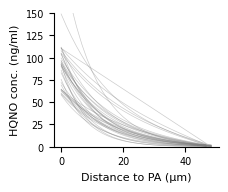

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ——— PNAS figure style ———
final_width_cm = 6    # width in cm
final_height_cm = 5   # height in cm
final_width_in = final_width_cm / 2.54
final_height_in = final_height_cm / 2.54
pnas_fontsize = 8  # points
plt.rcParams.update({
    'font.size': pnas_fontsize,
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

# Load profiles
PROFILES_CSV = '/Volumes/ScientificData/Users/Giulia(botgiu00)/Papers/bottacin2025/Analysis/Figures/Figures3/3C_hqno_concentration/3C_HQNO_concentration_profiles.csv'

df = pd.read_csv(PROFILES_CSV)

# Extract numeric replicate number from string (e.g., 'replicate_1' -> 1)
df['rep_num'] = df['replicate'].str.extract(r'(\d+)').astype(int)

# Filter for replicates 4, 5, 7 only
df = df[df['rep_num'].isin([4, 5, 7])].copy()

# Choose x-axis (physical if available, otherwise y_bin)
x_col = 'x_physical' if ('x_physical' in df.columns and df['x_physical'].notna().any()) else 'y_bin'
x_label = "Distance to PA (µm)" if x_col == 'x_physical' else "Distance to PA (bins)"

# Choose the concentration column (prefer HQNO naming, fallback to RHL if needed)
if 'estimated_hqno_concentration' in df.columns:
    conc_col = 'estimated_hqno_concentration'
elif 'estimated_rhl_concentration' in df.columns:
    conc_col = 'estimated_rhl_concentration'
else:
    raise ValueError("No concentration column found. Expected 'estimated_hqno_concentration' or 'estimated_rhl_concentration'.")

fit_col = 'fit_y' if 'fit_y' in df.columns else None

# Get replicates
reps = sorted(df['rep_num'].dropna().unique())

# Create figure with single axis for fits only
fig, ax = plt.subplots(figsize=(final_width_in, final_height_in))

# Plot all chamber fits (if available) - all in green like the reference
lines_plotted_fit = 0
if fit_col is not None:
    for rep in reps:
        drep = df[df['rep_num'] == rep]
        for pos, dpos in drep.groupby('pos'):
            dpos = dpos[[x_col, fit_col]].dropna().sort_values(x_col)
            if len(dpos) > 1:
                # Convert to numpy arrays explicitly
                x_data = dpos[x_col].values
                y_data = dpos[fit_col].values
                ax.plot(x_data, y_data, '-', lw=0.5, alpha=0.4, color='grey')
                lines_plotted_fit += 1
else:
    ax.text(0.5, 0.5, "No 'fit_y' column found", ha='center', va='center', transform=ax.transAxes)

# Labels and styling
ax.set_xlabel(x_label, fontsize=pnas_fontsize)
ax.set_ylabel('HQNO conc. (ng/ml)', fontsize=pnas_fontsize)
ax.tick_params(labelsize=pnas_fontsize-1)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Grid
#ax.grid(True, alpha=0.3, linewidth=0.5)

# Set y-limits
ax.set_ylim(bottom=0, top=150)

plt.tight_layout()
print(f"[info] Plotted {lines_plotted_fit} fit series from replicates {reps}.")

# Save outputs
plt.savefig('3C_HQNO_fits_PNAS.pdf', dpi=300, transparent=True)
#plt.savefig('3C_HQNO_fits_PNAS.png', dpi=300, transparent=True)
plt.show()


[info] Plotted 33 fit series from replicates [4, 5, 7].


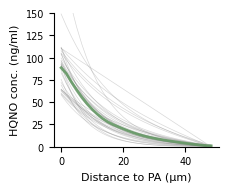

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

# ——— PNAS figure style ———
final_width_cm = 6    # width in cm
final_height_cm = 5   # height in cm
final_width_in = final_width_cm / 2.54
final_height_in = final_height_cm / 2.54
pnas_fontsize = 8  # points
plt.rcParams.update({
    'font.size': pnas_fontsize,
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

# Load profiles
PROFILES_CSV = '/Volumes/ScientificData/Users/Giulia(botgiu00)/Papers/bottacin2025/Analysis/Figures/Figures3/3C_hqno_concentration/3C_HQNO_concentration_profiles.csv'

df = pd.read_csv(PROFILES_CSV)

# Extract numeric replicate number from string (e.g., 'replicate_1' -> 1)
df['rep_num'] = df['replicate'].str.extract(r'(\d+)').astype(int)

# Filter for replicates 4, 5, 7 only
df = df[df['rep_num'].isin([4, 5, 7])].copy()

# Choose x-axis (physical if available, otherwise y_bin)
x_col = 'x_physical' if ('x_physical' in df.columns and df['x_physical'].notna().any()) else 'y_bin'
x_label = "Distance to PA (µm)" if x_col == 'x_physical' else "Distance to PA (bins)"

# Choose the concentration column (prefer HQNO naming, fallback to RHL if needed)
if 'estimated_hqno_concentration' in df.columns:
    conc_col = 'estimated_hqno_concentration'
elif 'estimated_rhl_concentration' in df.columns:
    conc_col = 'estimated_rhl_concentration'
else:
    raise ValueError("No concentration column found. Expected 'estimated_hqno_concentration' or 'estimated_rhl_concentration'.")

fit_col = 'fit_y' if 'fit_y' in df.columns else None

# Get replicates
reps = sorted(df['rep_num'].dropna().unique())

# Create figure with single axis for fits only
fig, ax = plt.subplots(figsize=(final_width_in, final_height_in))

# Collect all data for median calculation
all_x = []
all_y = []

# Plot all chamber fits (if available) - all in grey
lines_plotted_fit = 0
if fit_col is not None:
    for rep in reps:
        drep = df[df['rep_num'] == rep]
        for pos, dpos in drep.groupby('pos'):
            dpos = dpos[[x_col, fit_col]].dropna().sort_values(x_col)
            if len(dpos) > 1:
                # Convert to numpy arrays explicitly
                x_data = dpos[x_col].values
                y_data = dpos[fit_col].values
                ax.plot(x_data, y_data, '-', lw=0.5, alpha=0.3, color='grey')
                lines_plotted_fit += 1

                # Store for median calculation
                all_x.extend(x_data)
                all_y.extend(y_data)

    # Calculate and plot smoothed median line
    if len(all_x) > 0:
        df_all = pd.DataFrame({'x': all_x, 'y': all_y})
        median_by_x = df_all.groupby('x')['y'].median().reset_index()
        median_by_x = median_by_x.sort_values('x')

        # Convert to numpy arrays explicitly
        x_median = median_by_x['x'].values
        y_median = median_by_x['y'].values

        # Smooth the median line using moving average
        window_size = 3
        smoothed_y = uniform_filter1d(y_median, size=window_size, mode='nearest')

        ax.plot(x_median, smoothed_y, 
               color='#669966', linewidth=2, alpha=0.9, label='Smoothed median')
else:
    ax.text(0.5, 0.5, "No 'fit_y' column found", ha='center', va='center', transform=ax.transAxes)

# Labels and styling
ax.set_xlabel(x_label, fontsize=pnas_fontsize)
ax.set_ylabel('HQNO conc. (ng/ml)', fontsize=pnas_fontsize)
ax.tick_params(labelsize=pnas_fontsize-1)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set y-limits
ax.set_ylim(bottom=0, top=150)

plt.tight_layout()
print(f"[info] Plotted {lines_plotted_fit} fit series from replicates {reps}.")

# Save outputs
plt.savefig('3C_HQNO_fits_PNAS.pdf', dpi=300, transparent=True)
#plt.savefig('3C_HQNO_fits_PNAS.png', dpi=300, transparent=True)
plt.show()


[info] Plotted median and percentile bands from replicates [4, 5, 7].
[info] Number of x positions: 30


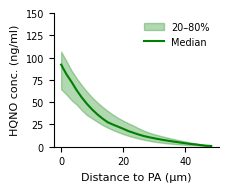

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ——— PNAS figure style ———
final_width_cm = 6    # width in cm
final_height_cm = 5   # height in cm
final_width_in = final_width_cm / 2.54
final_height_in = final_height_cm / 2.54
pnas_fontsize = 8  # points
plt.rcParams.update({
    'font.size': pnas_fontsize,
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

# Load profiles
PROFILES_CSV = '/Volumes/ScientificData/Users/Giulia(botgiu00)/Papers/bottacin2025/Analysis/Figures/Figures3/3C_hqno_concentration/3C_HQNO_concentration_profiles.csv'

df = pd.read_csv(PROFILES_CSV)

# Extract numeric replicate number from string (e.g., 'replicate_1' -> 1)
df['rep_num'] = df['replicate'].str.extract(r'(\d+)').astype(int)

# Filter for replicates 4, 5, 7 only
df = df[df['rep_num'].isin([4, 5, 7])].copy()

# Choose x-axis (physical if available, otherwise y_bin)
x_col = 'x_physical' if ('x_physical' in df.columns and df['x_physical'].notna().any()) else 'y_bin'
x_label = "Distance to PA (µm)" if x_col == 'x_physical' else "Distance to PA (bins)"

# Choose the fit column
fit_col = 'fit_y' if 'fit_y' in df.columns else None

if fit_col is None:
    raise ValueError("No 'fit_y' column found in the data.")

# Get replicates
reps = sorted(df['rep_num'].dropna().unique())

# Calculate percentiles across all chambers at each x position
# Group by x_col and calculate percentiles of fit_y
percentiles = df.groupby(x_col)[fit_col].agg([
    ('p20', lambda x: np.percentile(x.dropna(), 20)),
    ('p50', lambda x: np.percentile(x.dropna(), 50)),  # median
    ('p80', lambda x: np.percentile(x.dropna(), 80))
]).reset_index()

# Sort by x position
percentiles = percentiles.sort_values(x_col)

# Create figure
fig, ax = plt.subplots(figsize=(final_width_in, final_height_in))

# Extract data
x_data = percentiles[x_col].values
p20 = percentiles['p20'].values
p50 = percentiles['p50'].values
p80 = percentiles['p80'].values

# Plot 20-80% percentile band
ax.fill_between(x_data, p20, p80, alpha=0.3, color='green', label='20–80%')

# Plot median line
ax.plot(x_data, p50, '-', lw=1.5, color='green', label='Median')

# Labels and styling
ax.set_xlabel(x_label, fontsize=pnas_fontsize)
ax.set_ylabel('HQNO conc. (ng/ml)', fontsize=pnas_fontsize)
ax.tick_params(labelsize=pnas_fontsize-1)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set y-limits
ax.set_ylim(bottom=0, top=150)

# Legend
ax.legend(fontsize=pnas_fontsize-1, frameon=False, loc='upper right')

plt.tight_layout()
print(f"[info] Plotted median and percentile bands from replicates {reps}.")
print(f"[info] Number of x positions: {len(x_data)}")

# Save outputs
#plt.savefig('3C_HQNO_fits_PNAS.pdf', dpi=300, transparent=True)
#plt.savefig('3C_HQNO_fits_PNAS.png', dpi=300, transparent=True)
plt.show()
